In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("henryshan/google-stock-price")
print("Files:", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
dataset = pd.read_csv(os.path.join(path, csv_file))

Files: ['GOOG.csv']


In [3]:
# sort dates in ascending order

# Ensure Date column is datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Sort by date ascending
dataset = dataset.sort_values('Date').reset_index(drop=True)

### Retrieve only the Open column

In [4]:
df = dataset.loc[:, ["Open"]].values
print(type(df))
df.shape

<class 'numpy.ndarray'>


(4858, 1)

### Plot Open stock price

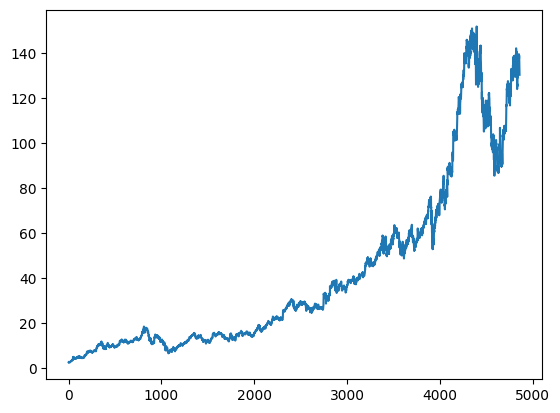

In [5]:
plt.plot(df)
plt.show()

### Scale Data

In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

# transform training data
df_scaled = sc.fit_transform(df)

### Set up data into X and y using a sliding window approach for time-series model fitting

In [7]:
def sliding_window(data_array, window_size):
    """
    Description:
    Divides the array of dimension: (n_samples, 1) into X and y using a sliding window

    Parameters:
    data_array(numpy array): The numpy array to split into X and y.
    window_size(int): The window size.

    Returns:
    X: The predicting variable or feature.
    y: The target variable
    """

    # Create X (features) and y (target)
    X, y = [], []
    for i in range(len(data_array) - window_size):
        X.append(data_array[i:i + window_size, 0])  # Extract 50 values
        y.append(data_array[i + window_size, 0])    # 51st value as target

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # reshape
    # np.reshape(This is the number of training examples (or data points) in the dataset, 
    #           Each sample contains a sequence of 50 values,
    #           This represents the number of features at each time step)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    print("X shape:", X.shape) 
    print("y shape:", y.shape)

    return X, y

In [8]:
window_size=50
X, y = sliding_window(data_array=df_scaled, window_size=window_size)

# split to 80% training and 20% test
train_split = int( len(X) * 0.8)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

X shape: (4808, 50, 1)
y shape: (4808,)


### Set up LTSM architecture

In [9]:
def build_model(params, input_shape):
    """
    Description:
    Creates an LTSM model

    Parameters:
    params:


    Returns:
    model: LTSM model
    """

    # Define LSTM model
    model = Sequential([
        Input(shape=input_shape), LSTM(params['units'], return_sequences=True),  # First LSTM layer
        Dropout(params['dropout']),  # Dropout to prevent overfitting

        LSTM(params['units'], return_sequences=True),  # Second LSTM layer (returns only the last output)
        Dropout(0.3),

        LSTM(params['units'], return_sequences=True),  # Third LSTM layer (returns only the last output)
        Dropout(params['dropout']),

        LSTM(params['units'], return_sequences=False),  #Fourth LSTM layer (returns only the last output)
        Dropout(params['dropout']),

        Dense(1, activation='relu'),  # Fully connected layer
    ])

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='mse', 
                  metrics=['mae'])

    # Display model summary
    model.summary()

    return model

### Tune Model

In [10]:
space = {'units': hp.choice('units', [32, 64, 128]),
         'dropout': hp.uniform('dropout', 0.1, 0.5),
         'learning_rate': hp.loguniform('learning_rate', -5, -2),
         'batch_size': hp.choice('batch_size', [16, 32, 64]),
         'epochs': hp.choice('epochs', [5, 10, 15])
         }


def objective(params):

    tf.keras.backend.clear_session()
    model = build_model(params, input_shape=(X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        verbose=0)
    val_loss = np.min(history.history['val_loss'])
    return {
        'loss': val_loss,
        'status': STATUS_OK
    }


trials = Trials()

best_params = fmin(fn=objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=5,
                   trials=trials)

best_params_mapped = {'units': [32, 64, 128][best_params['units']],
                      'batch_size': [16, 32, 64][best_params['batch_size']],
                      'epochs': [5, 10, 15][best_params['epochs']],
                      'dropout': best_params['dropout'],
                      'learning_rate': best_params['learning_rate']
}

print(best_params_mapped)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:From c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

 20%|██        | 1/5 [00:42<02:51, 42.92s/trial, best loss: 0.0017811035504564643]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 40%|████      | 2/5 [01:01<01:26, 28.76s/trial, best loss: 0.0017811035504564643]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

 60%|██████    | 3/5 [02:07<01:31, 45.59s/trial, best loss: 0.0016115799080580473]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

 80%|████████  | 4/5 [04:33<01:25, 85.08s/trial, best loss: 0.0013977199560031295]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 5/5 [06:23<00:00, 76.68s/trial, best loss: 0.0011109837796539068]
{'units': 128, 'batch_size': 32, 'epochs': 10, 'dropout': np.float64(0.10893921776045574), 'learning_rate': np.float64(0.0366778795196666)}


### Train final model with best hyper-parameters

In [11]:
model = build_model(best_params_mapped,
                    input_shape=(X_train.shape[1], X_train.shape[2])
)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

model.fit(X_train, 
          y_train,
          epochs=best_params_mapped['epochs'],
          batch_size=best_params_mapped['batch_size'],
          callbacks=[early_stop],
          verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 9.8185e-04 - mae: 0.0173
Epoch 2/10
  1/121 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 2.8327e-04 - mae: 0.0124

c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 1.9322e-04 - mae: 0.0095
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 1.9910e-04 - mae: 0.0098
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 2.0232e-04 - mae: 0.0099
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 2.2393e-04 - mae: 0.0103
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 1.7552e-04 - mae: 0.0091
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - loss: 1.5351e-04 - mae: 0.0086
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 25s 209ms/step - loss: 1.4475e-04 - mae: 0.0082
Epoch 9/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 24s 201ms/step - loss: 1.6691e-04 - mae: 0.0093
Epoch 10/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 25s 208ms/step - loss: 1.5397e-04 - mae: 0.0084


### Predict

In [12]:
# predict
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# check metrics
results = model.evaluate(X_test, y_test, return_dict=True, verbose=0)
mse = results['loss']
mae = results['mae']
print("MSE:", mse)
print("MAE:", mae)

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step
MSE: 0.0011264249915257096
MAE: 0.025859111919999123


### Plot

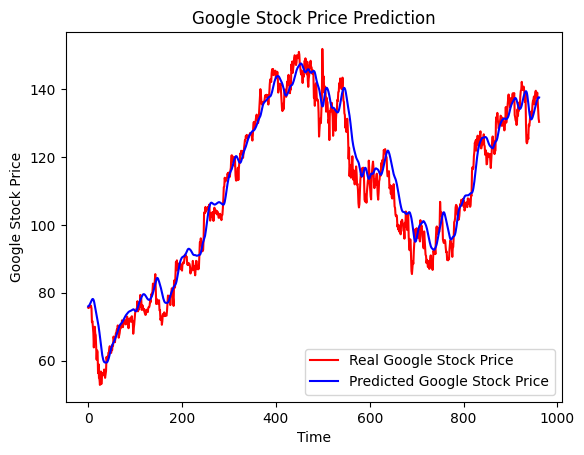

In [13]:

# transform test target variable to original form
y_test = sc.inverse_transform(y_test.reshape(-1, 1))

# visualising the results
plt.plot(y_test, color = "red", label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()